In [122]:
# import libraries
import pandas as pd
import dask.dataframe as dd
import os

from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [123]:
# load client and invoice datasets
client_test = pd.read_csv('data/client_test.csv')
client_train = pd.read_csv('data/client_train.csv')

invoice_train = pd.read_parquet('data/invoice_train_compressed.csv.parquet')
invoice_test = pd.read_parquet('data/invoice_test_compressed.csv.parquet')

In [124]:
invoice_train.columns

Index(['client_id', 'invoice_date', 'tarif_type', 'counter_number',
       'counter_statue', 'counter_code', 'reading_remarque',
       'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
       'consommation_level_3', 'consommation_level_4', 'old_index',
       'new_index', 'months_number', 'counter_type'],
      dtype='object')

In [125]:
# inspect client training dataset
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [126]:
client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


<Axes: title={'center': 'Distribution of Classifications'}, xlabel='prediction'>

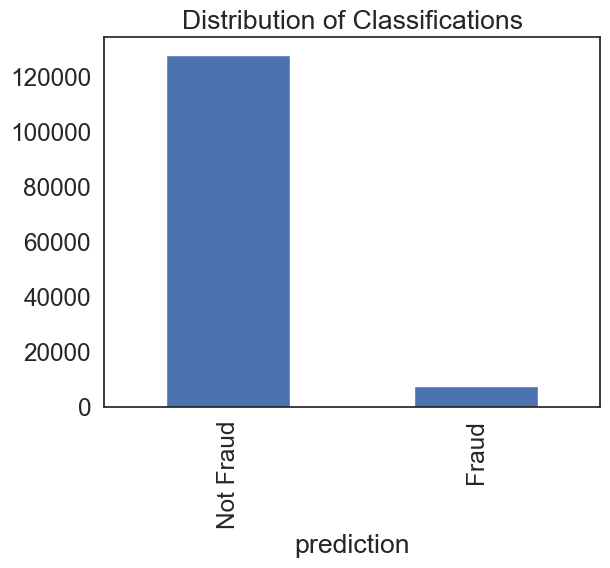

In [127]:
# Create a new column called prediction
client_train['prediction'] = np.where(client_train['target']==1, "Fraud", "Not Fraud")

# Then remove the target column
client_train.drop('target', axis=1, inplace=True)

client_train['prediction'].value_counts().plot(kind = 'bar', title = 'Distribution of Classifications')

Observation: <br>
This bar plot shows the distribution of fraud and non-fraud classifications in the training dataset. The training dataset is imbalanced, with more "Not Fraud" than "Fraud" classifications.

In [128]:
# check the column names to identify the common key for merging
print("\nClient Train Columns:", client_train.columns.tolist())
print("Invoice Train Columns:", invoice_train.columns.tolist())


Client Train Columns: ['disrict', 'client_id', 'client_catg', 'region', 'creation_date', 'prediction']
Invoice Train Columns: ['client_id', 'invoice_date', 'tarif_type', 'counter_number', 'counter_statue', 'counter_code', 'reading_remarque', 'counter_coefficient', 'consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4', 'old_index', 'new_index', 'months_number', 'counter_type']


In [130]:
# merge client and invoice training dataset
merged_train = pd.merge(invoice_train, client_train, on='client_id', how='inner')

In [ ]:
merged_train.info()

In [ ]:
merged_train.describe()

In [ ]:
# check for missing data
merged_train.isnull().sum()

In [ ]:
# Calculate the number of unique values in each numeric column
unique_values = merged_train.select_dtypes(include='number').nunique()

# Get the columns where there is only one unique value
zero_variance_columns = unique_values[unique_values == 1].index.tolist()

# Print the list of columns with zero variance (constant columns)
print("Columns with only one unique value (zero variance):", zero_variance_columns)

Conclusion: <br>
Since numerical columns are actually categorical, they represent discrete categories rather than continuous values. In this scenario, the standard variance calculation may not fully capture their importance, but columns with zero variance still indicate no variability in the data. For categorical columns, it may be more meaningful to look at unique counts rather than variance. This means those columns are constant across all rows and can be removed.

In [ ]:
# check for duplicated rows
merged_train[merged_train.duplicated()]

In [97]:
# Drop duplicate rows
merged_train = merged_train.drop_duplicates()

In [ ]:
# check for duplicated rows
merged_train[merged_train.duplicated()]

For categorical data, especially if it's encoded as integers, checking for outliers is generally not applicable in the same way it is for numerical data. For integer-encoded categorical data, checking for outliers in the traditional sense (e.g., using z-scores, interquartile ranges) is irrelevant because the values simply represent different categories. They are not continuous or ordinal numbers where "extreme values" could be identified.

In [ ]:
# check for imbalanced data

# Use the merged_train dataset and select relevant numerical columns
numeric_columns = [
    'disrict', 'client_catg', 'region', 
    'tarif_type', 'counter_number', 
    'reading_remarque', 'counter_coefficient', 
    'consommation_level_1', 'consommation_level_2',
    'consommation_level_3', 'consommation_level_4',
    'old_index', 'new_index', 'months_number'
]

# Set a smaller sample size for visualization to speed up the process
sample_size = 5000  # Reduced sample size
merged_sample = merged_train.sample(n=sample_size, random_state=42)

# Pre-calculate value counts for all numeric columns
value_counts = {col: merged_sample[col].value_counts() for col in numeric_columns}

# Set the number of rows and columns for subplots
num_vars = len(numeric_columns)
num_cols = 3  # Adjust this value based on how many columns you want in the grid
num_rows = (num_vars + num_cols - 1) // num_cols  # Calculate number of rows needed

# Create a figure and a set of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy indexing

# Iterate over each top correlated variable and plot
for i, feature in enumerate(numeric_columns):
    counts = value_counts[feature]
    axes[i].bar(counts.index.astype(str), counts.values)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Count')
    
    # Rotate x-axis labels for better readability and display only some ticks
    axes[i].tick_params(axis='x', rotation=45)
    
    # Show fewer x-ticks: display every nth label depending on unique values
    if len(counts.index) > 10:  # Adjust the number of ticks based on the length
        step = len(counts.index) // 10  # Show only about 10 labels
        axes[i].set_xticks(counts.index[::step].astype(str))

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
# check for curse of dimensionality

from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

# Randomly sample a subset of the data (e.g., 10,000 samples)
sample_size = 10000 
merged_sample = merged_train.sample(n=sample_size, random_state=42)

# Standardize the data for better distance computation
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_sample[numeric_columns])

# Function to plot histograms for given dimensions
def plot_histograms(data, dimensions, num_bins=50):
    plt.figure(figsize=(15, 10))
    
    for idx, dim in enumerate(dimensions):
        # Calculate Euclidean distances for the specified dimensions
        distances = pairwise_distances(data[:, :dim])
        distance_vector = distances[np.triu_indices(distances.shape[0], k=1)]
        
        # Calculate the standard deviation of distances
        sd = np.std(distance_vector)
        
        # Plot histogram
        plt.subplot(2, 2, idx + 1)
        plt.hist(distance_vector, bins=num_bins, density=True)
        plt.title(f'Dimensions: {dim}\nSD: {sd:.4f}')
        plt.xlabel('Euclidean Distance')
        plt.ylabel('Density')
        plt.grid(axis='y', alpha=0.75)

    plt.tight_layout()
    plt.show()

# Define dimensions to explore
dimensions_to_plot = [2, 3, 5, 10] 

# Plot histograms
plot_histograms(scaled_data, dimensions_to_plot)

Conclusion: <br>
The histogram of Euclidean distances shows that both standard deviation and variance increase as the number of dimensions grows. This suggests that the dataset has too many features, leading to sparsity, which makes it difficult to identify the true decision boundaries for classification. The high variance in the model, when fitting to sparse training data, increases the risk of overfitting.

In [ ]:
def plot_top_correlations(df: pd.core.frame.DataFrame, n: int, title_name: str = 'Pearson Correlation Coefficient') -> None:
    # Select only numeric columns
    numeric_cols = df.select_dtypes(include='number')

    # Calculate correlation between numeric variables
    corr = numeric_cols.corr()

    # Select variables having highest absolute correlation
    top_corr_cols = corr.abs().nlargest(n, columns=corr.columns).index
    top_corr = corr.loc[top_corr_cols, top_corr_cols]

    mask = np.zeros_like(top_corr)
    mask[np.triu_indices_from(mask)] = True
    heatmap = sns.heatmap(top_corr, mask=mask, annot=True , annot_kws={"size": 8}, 
                          cmap='coolwarm', fmt='.2f', 
                          linewidths=0.5, cbar=True, )
    plt.title(title_name, fontsize=14)
    plt.xticks(fontsize=8, rotation=90)
    plt.yticks(fontsize=8, rotation=0)

    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=8)

    plt.show()

# Plot heatmap of top 12 correlations in training data for numeric columns
plot_top_correlations(merged_train, 12, 'Pearson Correlation Coefficient')

Conclusion: <br>
The Pearson correlation coefficient measures the linear relationship between pairs of features, where values close to 1 indicate a strong positive correlation, values close to -1 indicate a strong negative correlation, and values around 0 indicate little or no linear relationship.

In [ ]:
# mitigate curse of dimensionality
from scipy import stats

# Select a smaller sample size
sample_size = 5000  # Adjusted sample size
merged_sample = merged_train.sample(n=sample_size, random_state=42)

# Select only numeric columns
numeric_cols = merged_sample.select_dtypes(include='number')

# Calculate correlation between numeric variables
corr = numeric_cols.corr()

# Select variables having highest absolute correlation (top 6)
top_corr = corr.abs().unstack().sort_values(ascending=False).drop_duplicates()
top_corr_pairs = top_corr[top_corr < 1].head(12).index.tolist()

# Create a list of unique pairs for plotting
top_corr_cols = list(set([pair[0] for pair in top_corr_pairs] + [pair[1] for pair in top_corr_pairs]))

# Function definitions for correlation and plotting
def corrdot(x, y, **kwargs):
    corr_r = x.corr(y, 'pearson')
    corr_text = round(corr_r, 4)
    ax = plt.gca()
    font_size = abs(corr_r) * 80 + 5
    ax.annotate(corr_text, [0.5, 0.5], xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

def corrfunc(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    ax = plt.gca()
    ax.annotate(p_stars, xy=(0.65, 0.6), xycoords=ax.transAxes,
                color='red', fontsize=70)

# Plotting
sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(merged_sample[top_corr_cols], aspect=1.5, diag_sharey=False, despine=False)
g.map_lower(sns.regplot, ci=False,
            line_kws={'color': 'red', 'lw': 1},
            scatter_kws={'color': 'black', 's': 20})
g.map_diag(sns.histplot, color='black', kde=True)
g.map_upper(corrdot)
g.map_upper(corrfunc)
g.fig.subplots_adjust(wspace=0, hspace=0)

# Remove axis labels
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

# Add titles to the diagonal axes/subplots
for ax, col in zip(np.diag(g.axes), top_corr_cols):
    ax.set_title(col, y=0.82, fontsize=26)

plt.show()


Conclusion: <br>
1. The corrrelation coefficients (numeric values on the upper half of the pairplot) represent the Pearson correlation coefficients between pairs of features. 
- Values near 1 indicate positive correlation meaning that as one variable increases, the other variable tends to increase.
- Values near -1 indicate negative correlation meaning that as one variable increases, the other variable tends to decrease.
- Values near 0 indicate weak or no linear relationship. 
<br>
2. Astericks show statistical significance of the correlations.
- `*` indicates p ≤ 0.05 (significant)
- `**` indicates p ≤ 0.01 (more significant)
- `***` indicates p ≤ 0.001 (highly significant)
<br>
3. Scatterplots and trendlines (lower half of the pairplot)
- The scatterplots show the relationships between pairs of features, with red trendlines indicating the direction of the relationships (positive or negative).
- A linear pattern would indicate a stronger relationship, while a dispersed or random pattern suggests weak or no relationship. <br>

The curse of dimensionality can lead to overfitting and increased computational complexity when working with many features. It’s important to reduce the number of features, especially those that add redundant or irrelevant information. Features that are highly correlated with each other may provide redundant information and can often be removed.

Features to consider reducing:
   - `old_index` and `new_index`: These have a very high correlation (close to 1, with a coefficient of 0.9959), meaning they essentially provide the same information. Including both in a machine learning model may be redundant, so you could drop one of them.
   - `client_catg` and `region`: They have a strong negative correlation (-0.8316), meaning they are inversely related. Depending on your model, you may want to choose one of them. <br>

Other highly correlated features:
   - `tariff_type` and `region` (0.4473) show moderate correlation.
   - `cbnsommation_level_3` and `cbnsommation_level_4` (0.3637) also show a strong positive correlation, indicating potential redundancy.

Weak correlations:
   - Some features, such as `district`, seem to have lower or no significant correlation with other features (as seen by smaller correlation values), suggesting they may not provide much predictive power and could potentially be ignored in feature selection.